# Reconnaissance faciale en utilisant  ACP
## Auteur : Anass GARBAZ

### I- Importation et visualisation des visages de la base Olivetti

1 - importation : 


        Dans cette partie de code on va importer 'fetch_olivetti_faces' de sklearn qui contient une base de données des visages. Puis, on importe PCA de sklearn aussi pour l'utilisation de l'ACP. 

In [ ]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA

on charge les visages dans faces et les targets dans labels. 

In [ ]:
olivetti = fetch_olivetti_faces()
faces = olivetti.images
labels = olivetti.target

2- visualisation des différents visages de Olivetti : 

        l'affichage en effet basé sur les targets ou encore labels pour identifier un unique visage 

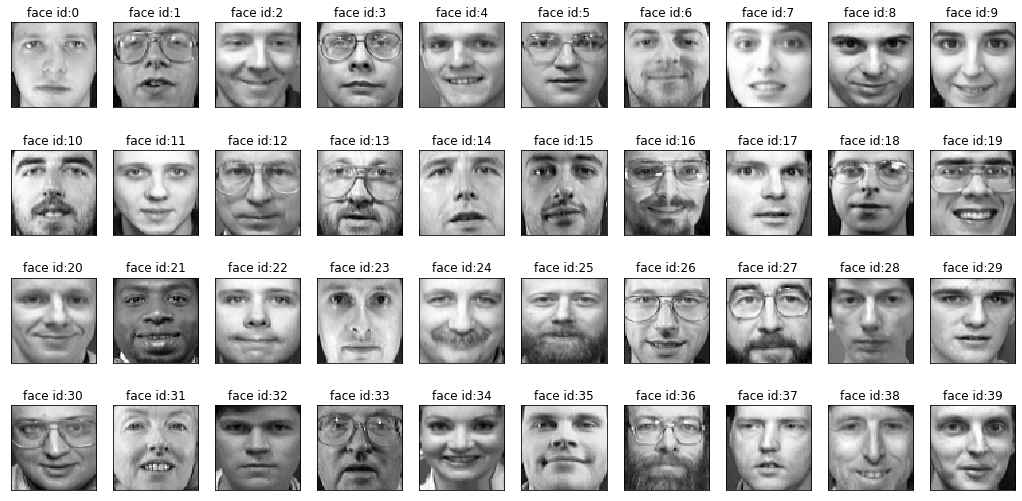

In [ ]:
fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
axarr=axarr.flatten()
for i in labels:
        image_index=i*10
        axarr[i].imshow(faces[image_index], cmap='gray')
        axarr[i].set_xticks([])
        axarr[i].set_yticks([])
        axarr[i].set_title("face id:{}".format(i))
#plt.imshow(faces[2],cmap='gray',interpolation='nearest')
#plt.show()


In [ ]:
# global centering
#faces_centered = faces - faces.mean(axis=0)

Dans cette base de données chaque personne a 10 images de visage de différent ambiances. On va afficher 5 personnes avec ses ambiances pour avoir une idée de la base  :

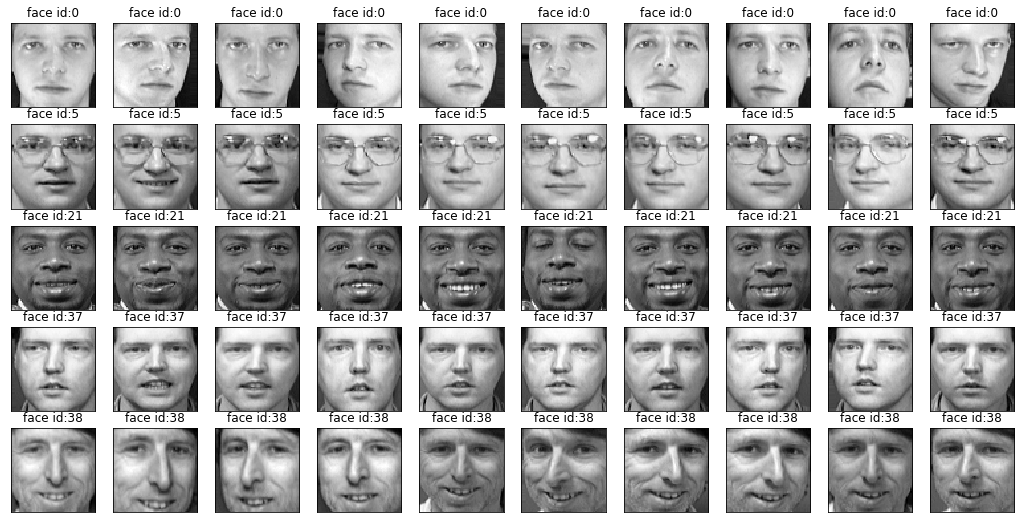

In [ ]:
subject_ids=[0,5, 21, 37, 38]
cols=10
fig, axarr=plt.subplots(nrows=len(subject_ids), ncols=cols, figsize=(18,9))                                                         
for i, subject_id in enumerate(subject_ids):
        for j in range(cols):
            image_index=subject_id*10 + j
            axarr[i,j].imshow(faces[image_index], cmap="gray")
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_title("face id:{}".format(subject_id))
    

### II - Analyse des principaux composants (ACP): 

#### 2 - ACP et eigenfaces (eigenvetors) : 

dans cette partie on va transformer  les images qui ont des tableaux de 3 dimension en vecteur. Puis, on va appeler la classe PCA pour l'appliquer à ces vecteurs et calculer les eigenfaces (eigenvectors) : 

construction des vecteurs : 

In [ ]:
faces_vectors = []
for image in faces:
    faces_vectors.append(image.flatten())
               


l'instanciation de la classe PCA avec K = 6 sur les vecteurs des visages : 

In [ ]:
pca = PCA(n_components=6).fit(faces_vectors)

Construction des eigenfaces : 

In [ ]:
eigen_faces=pca.components_.reshape((6, faces.shape[1], faces.shape[2]))

puis on va changer les dimensions de faces et les remettre dans la variable X :

In [ ]:
#We reshape images for machine learnig  model
X=faces.reshape((faces.shape[0],faces.shape[1]*faces.shape[2]))
print("X shape:",X.shape)

X shape: (400, 4096)


Maintenant, on va appeller train_test_split de sklearn pour découper les les données : 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, labels, test_size=0.3, stratify=labels, random_state=0)

Il faut visualiser le scree plot pour voir combien de PC nous faut : 

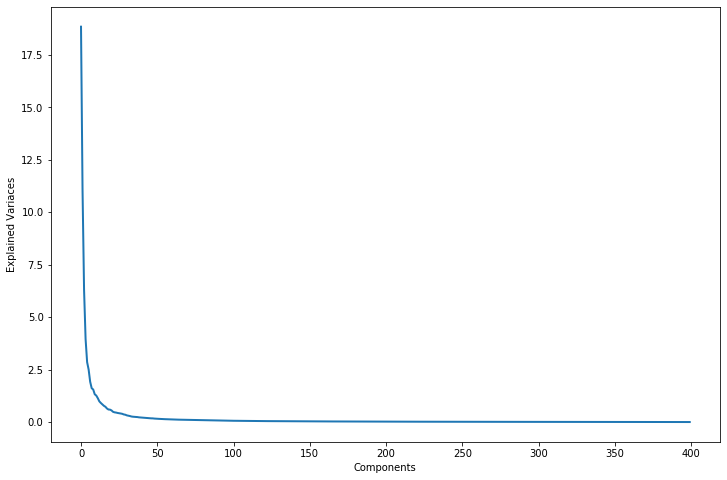

In [ ]:
pca=PCA()
pca.fit(X)

plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

On voit qu'il faut prendre k = 90. On va visualiser encore en fonction de cumsum pour vérifier que  vraiment k = 90

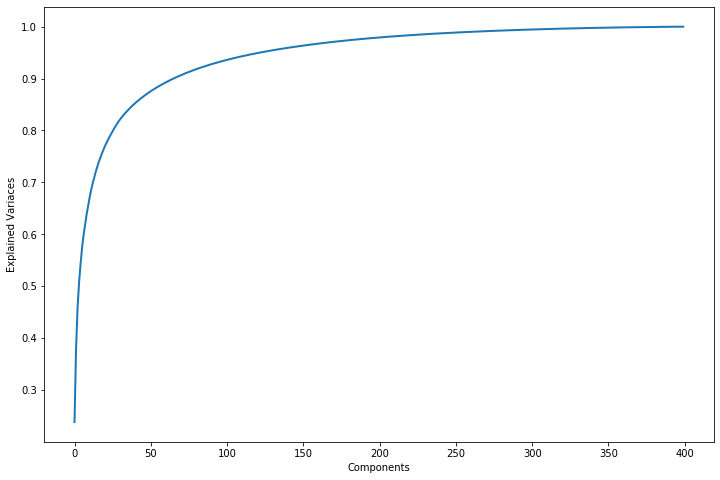

In [ ]:
pca=PCA()
pca.fit(X)
plt.figure(1, figsize=(12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

Il est claire que k = 90 mais dans notre cas on va prendre seulement k = 6. 

In [ ]:
pca=PCA(n_components=6, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

Affichage de visage moyen (mean face) : 

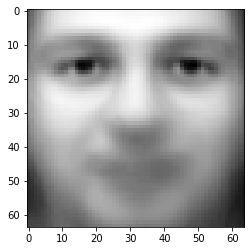

In [ ]:
# the mean face
plt.imshow(pca.mean_.reshape((64,64)),cmap='gray',interpolation='nearest')
plt.show()

Finalement, on affiche les 6 eigenfaces : 

Text(0.5, 0.98, 'Eigen Faces')

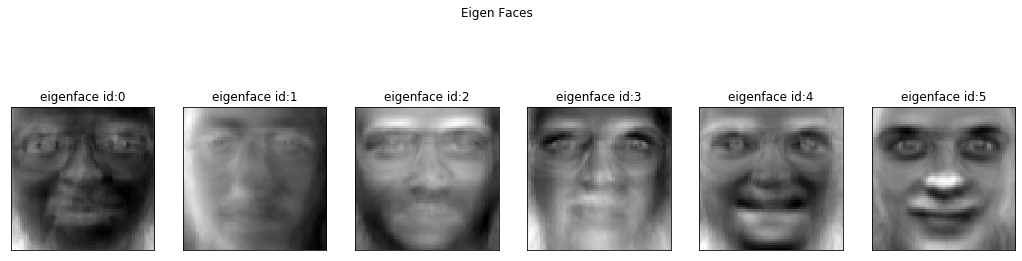

In [ ]:
number_of_eigenfaces=len(pca.components_)

eigen_faces=pca.components_.reshape((number_of_eigenfaces, faces.shape[1], faces.shape[2]))

fig, axarr=plt.subplots(nrows=1, ncols=6, figsize=(18, 5))

axarr=axarr.flatten()
for i in range(len(eigen_faces)):
        
        axarr[i].imshow(eigen_faces[i], cmap='gray')
        axarr[i].set_xticks([])
        axarr[i].set_yticks([])
        axarr[i].set_title("eigenface id:{}".format(i))
plt.suptitle("Eigen Faces".format(10*"=", 10*"="))
#plt.imshow(faces[2],cmap='gray',interpolation='nearest')
#plt.show()




## III - Reconnaissance faciale en se basant sur les eigenfaces : 
                      
              

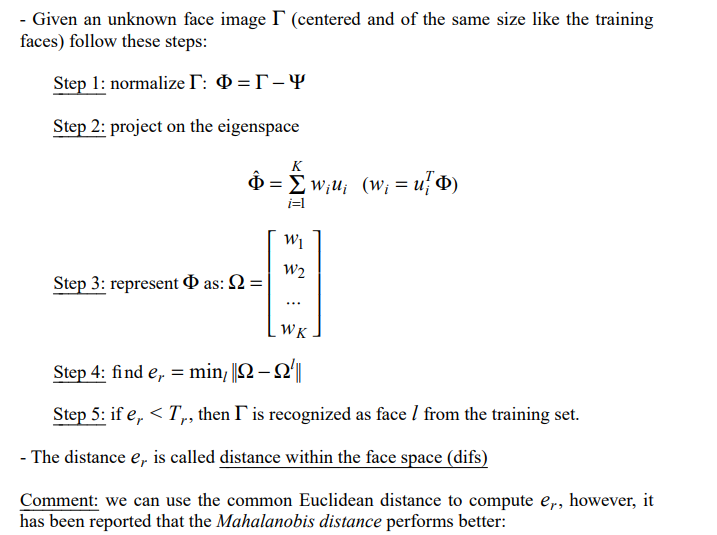<img src="rf.png">

Step 0 : donner une image (convertir en vecteur) pour laquelle on va faire le test pour trouver le visage similaire  : 

In [ ]:
face_req = faces[12].flatten()


Calcule de vecteur de visage moyen  : 

In [ ]:
faces_vectors = []
for image in faces:
    faces_vectors.append(image.flatten())

In [ ]:
#avg_face = np.sum(faces_vectors,axis=0)
avg_face = np.add.reduce(faces_vectors) / len(faces_vectors)
print(avg_face)


[0.40013435 0.43423545 0.4762809  ... 0.32141536 0.3136469  0.31045464]


Step 1 : 

In [ ]:
sigma = face_req - avg_face
print(sigma)

[ 0.25689045  0.24345052  0.2220662  ... -0.20571288 -0.19794443
 -0.20714885]


Step 2 : 

on fait changer les images de 3 dim en un seul vecteur Ui : 

In [ ]:
u = []
for image in eigen_faces:
    u.append(image.flatten())

In [ ]:
print(u[5])

[ 0.03771556  0.04290356  0.04188165 ... -0.01074013 -0.00816379
 -0.00523486]


on calcule les Wi : 

In [ ]:
w = []
for i in range(len(u)):
    w.append(np.transpose(u[i]) * sigma )

In [ ]:
u_vectors = []
for i in range(len(u)):
    u_vectors.append(u[i].flatten())

In [ ]:
print(u_vectors[0])

[-0.00374081 -0.00722669 -0.00930005 ...  0.00108423  0.00419549
  0.00314182]


step 1 pour tout les eigenfaces

In [ ]:
sigma_base = []
for i in range(len(u)):
    sigma_base.append(u[i] - avg_face)
print(sigma_base[0])

[-0.40387517 -0.44146213 -0.48558095 ... -0.32033113 -0.30945143
 -0.30731282]


step 3

In [ ]:
w_base = []
u1_base = []
u2_base = []
u3_base = []
u4_base = []
u5_base = []
u0_base = []

for j in range(len(u)):
     u0_base.append(sigma_base[0] * np.transpose(u[j]) )
for j in range(len(u)):
     u1_base.append(np.transpose(u[j]) * sigma_base[1] )
for j in range(len(u)):
     u2_base.append(np.transpose(u[j]) * sigma_base[2] )
for j in range(len(u)):
     u3_base.append(np.transpose(u[j]) * sigma_base[3] )
for j in range(len(u)):
     u4_base.append(np.transpose(u[j]) * sigma_base[4] )
for j in range(len(u)):
     u5_base.append(np.transpose(u[j]) * sigma_base[5] )

        
w_base.append(u0_base)
w_base.append(u1_base)
w_base.append(u2_base)
w_base.append(u3_base)
w_base.append(u4_base)
w_base.append(u5_base)

In [ ]:
print(u0_base)

[array([ 0.00151082,  0.00319031,  0.00451593, ..., -0.00034731,
       -0.0012983 , -0.00096552], dtype=float32), array([-0.01271875, -0.01567617, -0.01919485, ...,  0.00934393,
        0.00825657,  0.00710017], dtype=float32), array([ 0.00036222,  0.00045357, -0.00012932, ...,  0.00457213,
        0.00400172,  0.00351961], dtype=float32), array([-0.00167763, -0.00010541,  0.00481041, ..., -0.00962101,
       -0.00887218, -0.00790237], dtype=float32), array([-0.00634895, -0.00634219, -0.00657856, ..., -0.01509476,
       -0.01361392, -0.01395863], dtype=float32), array([-0.01523238, -0.0189403 , -0.02033693, ...,  0.0034404 ,
        0.0025263 ,  0.00160874], dtype=float32)]


Step 4

In [ ]:
dist = []
for i in range(len(u)):
    dist.append(np.add.reduce(np.subtract(w,w_base[i])**2))
print(dist)

[array([1.1759549e-03, 1.5768413e-03, 1.8452718e-03, ..., 5.6407902e-05,
       4.6264035e-05, 3.4378347e-05], dtype=float32), array([1.0538927e-03, 1.3862012e-03, 1.5993996e-03, ..., 9.0116002e-05,
       7.5432814e-05, 5.4754986e-05], dtype=float32), array([1.1658540e-03, 1.5484262e-03, 1.7957182e-03, ..., 7.2536423e-05,
       6.1567553e-05, 4.5126624e-05], dtype=float32), array([1.1480229e-03, 1.5426542e-03, 1.8484358e-03, ..., 3.1511481e-05,
       2.8183527e-05, 2.0629517e-05], dtype=float32), array([1.1077066e-03, 1.4789838e-03, 1.7280385e-03, ..., 2.0194311e-05,
       1.9133016e-05, 1.1481069e-05], dtype=float32), array([1.0330253e-03, 1.3544639e-03, 1.5880002e-03, ..., 6.8646652e-05,
       5.7088058e-05, 4.0368901e-05], dtype=float32)]


In [ ]:
dist_sum = []
for i in range(len(u)):
    dist_sum.append(np.add.reduce(dist[i]))



In [ ]:
minimum = dist_sum.index(min(dist_sum))
print( minimum )


1


### Résultat : l'affichage de eigenface correspondant : 

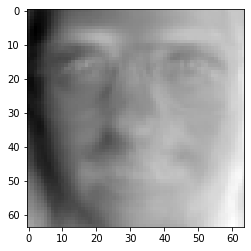

In [ ]:
plt.imshow(eigen_faces[minimum],cmap='gray',interpolation='nearest')
plt.show()

## VI -  détection de visage : 

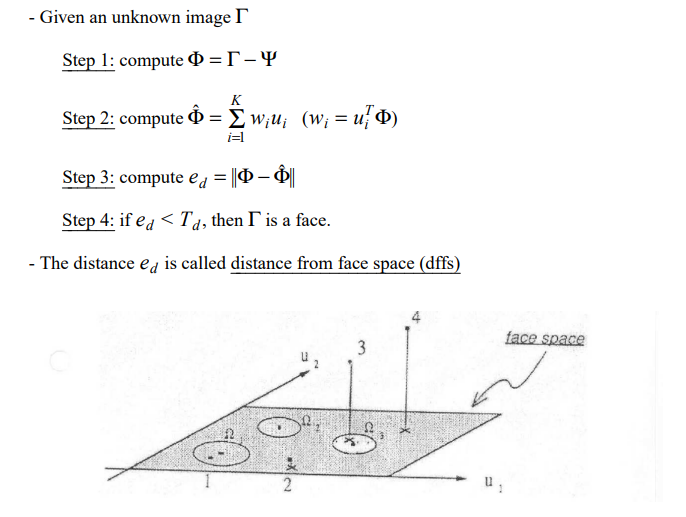<img src="fd.png">

step 1 : 

In [ ]:
face_req1 = faces[12].flatten()


In [ ]:
sigma1 = face_req1 - avg_face
print(sigma)

[ 0.25689045  0.24345052  0.2220662  ... -0.20571288 -0.19794443
 -0.20714885]


step 2 : 

In [ ]:
w = []
for i in range(len(u)):
    w.append(np.transpose(u[i]) * sigma1 )


In [ ]:
eigenspaces = []
eigenspaces_prod = []

In [ ]:
for i in range(len(u)):
    eigenspaces_prod.append( np.transpose(w[i]) * u[i])

In [ ]:
eigenspaces = np.add.reduce(eigenspaces_prod)

step 3 : 

In [ ]:
def calculateDistance(i1, i2):
    return np.sqrt(np.sum((i1-i2)**2))


### Résultat : 

In [ ]:
Td = 10
if calculateDistance(sigma, eigenspaces)<= Td:
    print('Image saisie est un visage')

Image saisie est un visage
